# 🧠 Model 3: CNN with Global Average Pooling
Improved architecture for stability and better learning.

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:

# 🔁 Enhanced Data Augmentation
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor()
])


In [6]:

# 🎯 Optional Label Smoothing Loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, target):
        log_probs = self.log_softmax(x)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=1))

# Replace loss function:
criterion = LabelSmoothingLoss(classes=7, smoothing=0.1)


In [7]:

# Dataset paths and transforms
train_dir = 'Data/train'
test_dir = 'Data/test'

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load datasets
full_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = test_transform
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = full_dataset.classes


In [8]:

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attention = torch.sigmoid(self.conv(x_cat))
        return x * attention


In [9]:

class SlimAttentionCNN(nn.Module):
    def __init__(self):
        super(SlimAttentionCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.attention = SpatialAttention()
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(128, 7)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.attention(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

model = SlimAttentionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [12]:
num_epochs = 10  # Limited time

# Scheduler setup:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


In [13]:
# Training loop
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Step the learning rate scheduler
    scheduler.step()

    # Calculate average training loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation step
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation accuracy
    val_acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f} | Val Accuracy: {val_acc:.4f}")


Epoch [1/10] | Loss: 1.7411 | Val Accuracy: 0.2432
Epoch [2/10] | Loss: 1.6962 | Val Accuracy: 0.2879
Epoch [3/10] | Loss: 1.6654 | Val Accuracy: 0.3059
Epoch [4/10] | Loss: 1.6319 | Val Accuracy: 0.3696
Epoch [5/10] | Loss: 1.6047 | Val Accuracy: 0.3482
Epoch [6/10] | Loss: 1.5805 | Val Accuracy: 0.3614
Epoch [7/10] | Loss: 1.5560 | Val Accuracy: 0.3994
Epoch [8/10] | Loss: 1.5370 | Val Accuracy: 0.3897
Epoch [9/10] | Loss: 1.5222 | Val Accuracy: 0.4043
Epoch [10/10] | Loss: 1.5158 | Val Accuracy: 0.4133


In [6]:

# Test set evaluation
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.numpy())

test_acc = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.4538


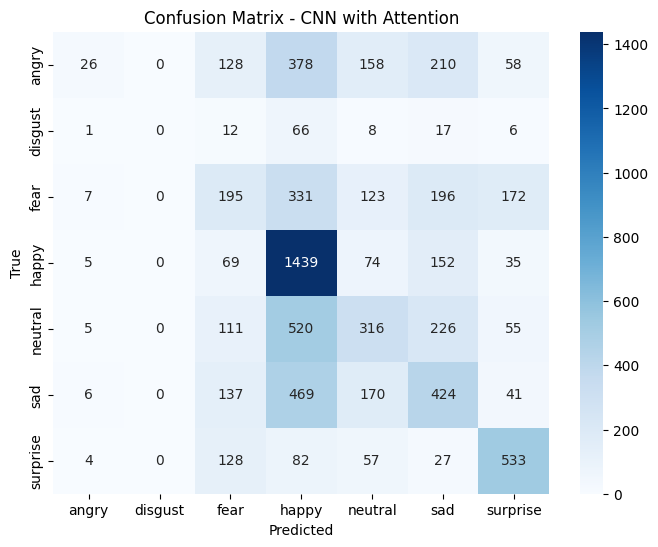

In [14]:
# 📊 Confusion Matrix for CNN + Attention Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN with Attention')
plt.show()


In [12]:

# Predict on custom image
test_image_path = 'hmy_image3.jpg'

image = Image.open(test_image_path).convert('L').convert('RGB')
image = test_transform(image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(image)
    probs = torch.softmax(output, dim=1)
    _, predicted = torch.max(probs, 1)
    predicted_class = class_names[predicted.item()]
    confidence = probs[0][predicted.item()].item()

print(f"Predicted Emotion: {predicted_class} ({confidence*100:.2f}% confidence)")


Predicted Emotion: happy (29.81% confidence)
